# satCORPS Conventional netCDF load with mask-based subsetting

In [1]:
import pystare
import starepandas
import geopandas
import pandas

import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import datetime

import regionmask
import xarray
from shapely.geometry import Polygon

import dask

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

In [2]:
class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

## Construct a mask for the region of interest

### First get the boundary from geopandas

In [3]:
start0 = datetime.datetime.now()

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# world.plot()

In [5]:
conus_boundary = world[world['name'] == 'United States of America'].clip(
    Polygon([(-125,24.5),(-66,24.5),(-66,49.5),(-125,49.5)])
).boundary

In [6]:
timings.add('time to construct boundary',datetime.datetime.now() - start0)

time to construct boundary 0:00:00.084163


### Load the composite data file to get the grid parameters

In [7]:
with xarray.open_dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc'
                         ,engine='netcdf4'
                         ,group='map_data'
                         ,decode_times=False
                        ) as file_nc:
     composite_file_nc = file_nc

In [8]:
lons = composite_file_nc.lon[:]
lats = composite_file_nc.lat[:]
lon, lat = numpy.meshgrid(lons, lats)

### Construct the mask using regionmask

In [9]:
my_regions = regionmask.Regions(conus_boundary)
mask = my_regions.mask(lon,lat)

/Users/mrilee/opt/anaconda3/envs/pystare-dev-1/lib/python3.10/site-packages/regionmask/core/regions.py:108: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  regions[n] = _OneRegion(n, names[n], abbrevs[n], outlines[n])


In [10]:
timings.add('time to construct boundary & mask',datetime.datetime.now() - start0)

time to construct boundary & mask 0:00:32.042013


### Load the composite data

In [11]:
start0 = datetime.datetime.now()

In [12]:
with xarray.load_dataset('ignored/satCORPS/composite_20220420_2019.182.0230.nc'
                         ,engine='netcdf4'
                         ,group='map_data'
                         ,decode_times=False
                        ) as file_nc:
     composite_file_nc = file_nc

timings.add('time to open/read data',datetime.datetime.now() - start0)

time to open/read data 0:00:32.966155


### Apply the mask

In [13]:
start0 = datetime.datetime.now()

In [14]:
BT12um_masked=composite_file_nc['BT_12.0um'].where(~numpy.isnan(mask.data))

timings.add('time to mask variable',datetime.datetime.now() - start0)

time to mask variable 0:00:00.201059


## Plot the data using contourf on the gridded data

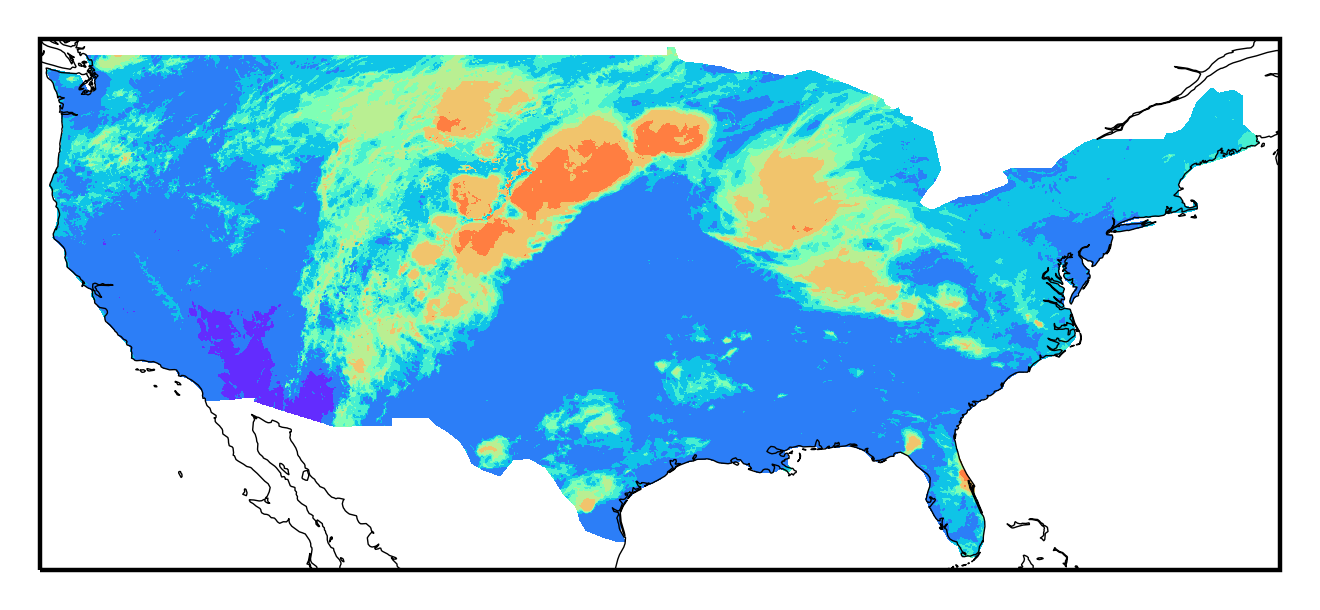

time to start contourf 0:00:19.384764


In [15]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
# ax.set_global()
ax.set_xlim(-125,-66)
ax.set_ylim(24.5,49.75)

# BT12um_masked.plot(ax=ax,transform=ccrs.PlateCarree())
ax.contourf(lon,lat,BT12um_masked,transform=ccrs.PlateCarree(),cmap='rainbow_r')

ax.coastlines(linewidth=0.25)

plt.show()
del fig,ax

timings.add('time to start contourf',datetime.datetime.now() - start0)

In [16]:
timings.add('total time to contourf',datetime.datetime.now() - start0)

total time to contourf 0:00:19.395552


## Timing report summary

In [17]:
timings.print_report(fmt="{:70} {:>6.2f}")

time to construct boundary                                               0.08
time to construct boundary & mask                                       32.04
time to open/read data                                                  32.97
time to mask variable                                                    0.20
time to start contourf                                                  19.38
total time to contourf                                                  19.40


## Plot the masked data using scatterplot for comparison to other methods

time to start scatter plot 0:00:13.501666


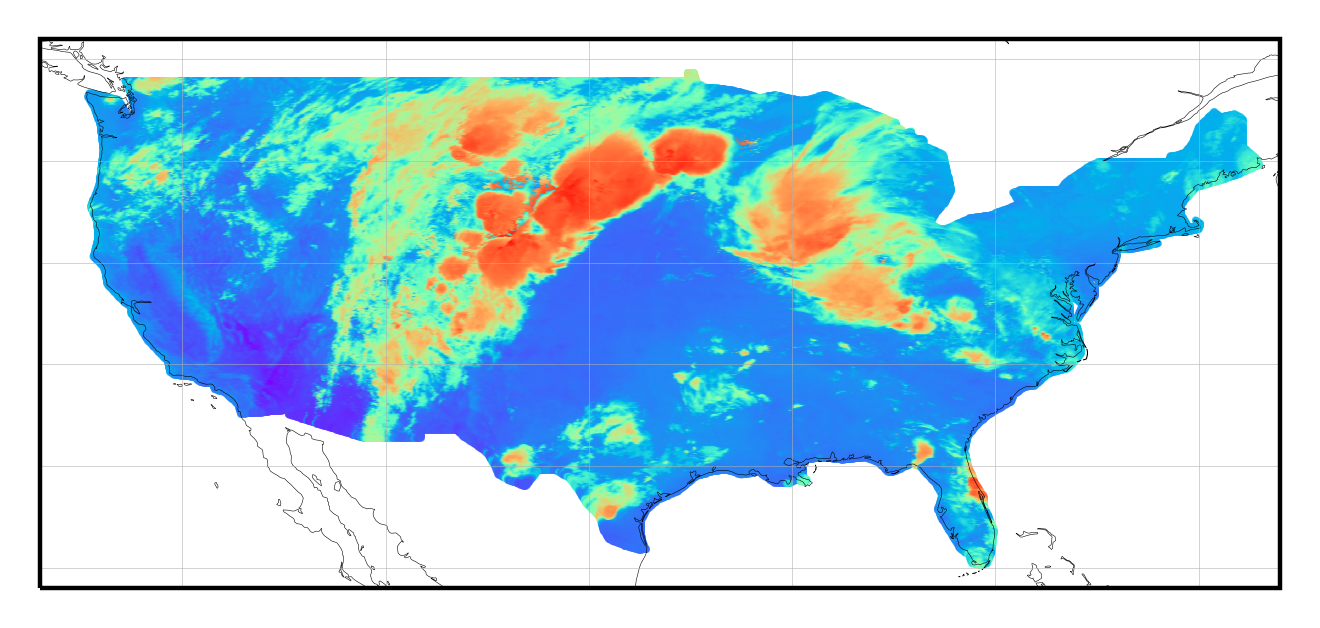

In [18]:
start0 = datetime.datetime.now()

fig, ax = plt.subplots(figsize=(4,4), dpi=400
                        ,subplot_kw=plot_options
                      )
ax.gridlines(linewidth=0.1)
# ax.set_global()
ax.coastlines(linewidth=0.1)

if True:
    # x0 = 166; y0 = -15; dlim = 0.5
    # x0 = 165.5; y0 = -17.5; dlim = 3.75
    # dlimx = dlim; dlimy = dlim
    x0 = -127; y0 = 24; dlimx = 61; dlimy = 27; dlim=dlimy
    
    ax.set_xlim(x0,x0+dlimx)
    ax.set_ylim(y0,y0+dlimy)

    marker_size=40.0/(dlim**2) # good for 'o'
    marker_size=27.0/(dlim**2) # good for 's'
    marker_alpha=0.5
else:
    ax.set_aspect('equal')
    marker_size=0.01
    marker_alpha=0.5
    
marker='s'

# df.plot(ax=ax,column='map_data/BT_12.0m',zorder=1,cmap='OrRd',trixels=True)
# df.plot(ax=ax,zorder=1,color='red',trixels=False,boundary=True)

ax.scatter(lon,lat
            ,s=marker_size
            ,c=BT12um_masked.data
            ,alpha=marker_alpha
#            ,cmap='nipy_spectral'
            ,cmap='rainbow_r'
            ,marker=marker
            ,rasterized=True
            ,transform=ccrs.PlateCarree()
            )
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)
# plt.scatter(df['lons'],jdf1['lats'],s=marker_size,color='k',alpha=marker_alpha)

if False:
    # bdf.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.25)
    roi.plot(ax=ax, trixels=True, boundary=True, color='k', zorder=1, linewidth=0.5)
    
if False:
    conus1.plot(ax=ax, trixels=False, facecolor="none", edgecolor='yellow', zorder=1, linewidth=1.5)
    
del fig,ax

timings.add('time to start scatter plot',datetime.datetime.now()-start0)

In [19]:
timings.add('total time to scatter',datetime.datetime.now() - start0)

total time to scatter 0:11:56.470205


## Timing report summary

In [20]:
timings.print_report(fmt="{:70} {:>6.2f}")

time to construct boundary                                               0.08
time to construct boundary & mask                                       32.04
time to open/read data                                                  32.97
time to mask variable                                                    0.20
time to start contourf                                                  19.38
total time to contourf                                                  19.40
time to start scatter plot                                              13.50
total time to scatter                                                  716.47
